# Reward Function Validation - Distance to goal

From [Policy Invariance under Reward Transformations](https://people.eecs.berkeley.edu/~pabbeel/cs287-fa09/readings/NgHaradaRussell-shaping-ICML1999.pdf) paper

In [3]:
# Load the track to exercise
from math import log
#Shapely Library
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline


In [4]:

TRACK_NAME = 'Canada_Training'

# Helper functions


# Visualize the Track and Waypoints

# Tracks Available::
# AWS_track                Straight_track                Oval_track
# Bowtie_track             H_track                       reinvent_base
# China_track              Mexico_track                  Canada_training

waypoints = np.load("tracks/%s.npy" % TRACK_NAME)
print("Waypoints shape: {}".format(waypoints.shape))

center_line = waypoints[:,0:2]
inner_border = waypoints[:,2:4]
outer_border = waypoints[:,4:6]
l_center_line = LineString(waypoints[:,0:2])
l_inner_border = LineString(waypoints[:,2:4])
l_outer_border = LineString(waypoints[:,4:6])
road_poly = Polygon(np.vstack((l_outer_border, np.flipud(l_inner_border))))

# Print some useful track analysis data
print("Centerline length: %0.2f" % l_center_line.length)
print("Track bounds: ", road_poly.bounds)
print(waypoints[0])
print("Track width: ", np.linalg.norm(waypoints[0,4:6] - waypoints[0,2:4]))
#print("Track y min/max: ", pd.DataFrame(outer_border)['y'])
road_poly

print(np.array_repr(center_line))

Waypoints shape: (203, 6)
Centerline length: 21.74
Track bounds:  (0.5871459377974991, -3.1185757246211283, 9.349370097060229, 3.0140815800413567)
[4.60918546 1.6430465  4.58646449 1.30659668 4.63079245 1.97884398]
Track width:  0.6737072087508159
array([[ 4.60918546,  1.6430465 ],
       [ 4.50431919,  1.67146498],
       [ 4.39907455,  1.69846398],
       [ 4.29348302,  1.72413248],
       [ 4.18765545,  1.74877203],
       [ 4.08169842,  1.77272302],
       [ 3.975631  ,  1.79626352],
       [ 3.86950552,  1.81977445],
       [ 3.76360047,  1.8441065 ],
       [ 3.65815759,  1.8700285 ],
       [ 3.55305755,  1.89752454],
       [ 3.44811702,  1.92617106],
       [ 3.34326446,  1.95471454],
       [ 3.23838747,  1.98214352],
       [ 3.13192952,  2.00926554],
       [ 3.02654493,  2.04065853],
       [ 2.92398453,  2.07964951],
       [ 2.82595205,  2.12832248],
       [ 2.73254597,  2.18519408],
       [ 2.64291656,  2.2447015 ],
       [ 2.55430901,  2.30580747],
       [ 2.466445

Text(4.817766904830933, 1.5820860266685486, '200')

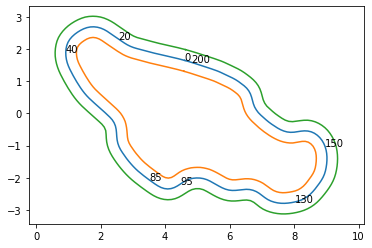

In [5]:
# scan the track and invoke the reward function for each waypoint

# Sections of Canada_Training
plt.plot(center_line[:,0:1], center_line[:,1:2])
plt.plot(inner_border[:,0:1], inner_border[:,1:2])
plt.plot(outer_border[:,0:1], outer_border[:,1:2])
plt.axis('equal')
plt.annotate('0', center_line[0])
# Straight
plt.annotate('20', center_line[20])
# Sharp left
plt.annotate('40', center_line[40])
# Straight
plt.annotate('85', center_line[85])
# Easy left
plt.annotate('95', center_line[95])
# Straight
plt.annotate('130', center_line[130])
# Easy left
plt.annotate('150', center_line[150])
# Straight
plt.annotate('200', center_line[200])

# Reward function code here

In [14]:
"""
AWS DeepRacer reward function using only progress
"""

#===============================================================================
#
# REWARD
#
#===============================================================================

def reward_function(params):
    # Skipping the explanation and verbose math here...
    distance_to_goal = 100.0 - params['progress']
    
    reward = params['progress']
    # 1e-8 is a crash so we ALWAYS need to be higher than that
    return float(max(reward, 1e-3))

# Test the reward function

In [13]:
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm

def rewards_for_episode(max_progress, nsteps):
    episode_reward = 0.0
    step_rewards = list()
    for i in range(nsteps+1):
        progress = i * (max_progress / nsteps)
        interpolate = l_center_line.interpolate(progress, normalized=True)
        reward = reward_function({'x': interpolate.x, 'y': interpolate.y, 'progress': progress, 'steps': i})
        episode_reward += reward
        step_rewards.append((i, progress, reward, episode_reward))
    return pd.DataFrame(step_rewards, columns=('step', 'progress', 'reward', 'total_reward'))
#    return step_rewards


rewards = list()
steps = 0
round_robin = 0.40  # 40% into the track
total_episode_reward = 0.0
TOTAL_STEPS = 60
for progress in np.linspace(0.65, 100.0, num=TOTAL_STEPS):
    ndist = (progress / 100.0) + round_robin
    if ndist > 1.0:
        ndist = ndist - 1.0
    interpolate = l_center_line.interpolate(float(ndist), normalized=True)
    reward = reward_function({'x': interpolate.x, 'y': interpolate.y, 'progress': progress, 'steps': steps})
    print("progress: ", progress, "step: ", steps, "reward: ", reward, " total: ", total_episode_reward)
    total_episode_reward = total_episode_reward + reward
    rewards.append((interpolate.x, interpolate.y, progress, steps, reward))
    steps = steps + 1
    
#pd.DataFrame(rewards, columns=('x','y','progress','step','reward'))
print("Total episode reward: ", total_episode_reward)
#rewards_for_episode(10,10).tail(1)['total_reward'].values[0]
#df = rewards_for_episode(100,200)
#i = 30
#progress = i * (100 / 200)
#interpolate = l_center_line.interpolate(i, normalized=True)
#reward = progress_factor({'x': interpolate.x, 'y': interpolate.y, 'progress': progress, 'steps': i})
#print("g_start_offset_percent: ", g_start_offset_percent)
#print("reward: ", reward)
#df.head(50)

progress:  0.65 step:  0 reward:  1.6500000000000057  total:  0.0
progress:  2.3338983050847455 step:  1 reward:  3.3338983050847446  total:  1.6500000000000057
progress:  4.0177966101694915 step:  2 reward:  5.017796610169498  total:  4.98389830508475
progress:  5.701694915254237 step:  3 reward:  6.701694915254237  total:  10.001694915254248
progress:  7.385593220338983 step:  4 reward:  8.38559322033899  total:  16.703389830508485
progress:  9.069491525423729 step:  5 reward:  10.069491525423729  total:  25.088983050847474
progress:  10.753389830508473 step:  6 reward:  11.753389830508468  total:  35.1584745762712
progress:  12.437288135593219 step:  7 reward:  13.43728813559322  total:  46.91186440677967
progress:  14.121186440677965 step:  8 reward:  15.12118644067796  total:  60.34915254237289
progress:  15.805084745762711 step:  9 reward:  16.805084745762713  total:  75.47033898305085
progress:  17.488983050847455 step:  10 reward:  18.48898305084745  total:  92.27542372881356
p

In [145]:

# make a plot of rewards
episode_rewards = list()
for progress in range(1,100):
    for steps in range(100,200):
        reward = rewards_for_episode(progress,steps)
        #print(reward)
        episode_rewards.append(reward[-1])

plot_df = pd.DataFrame(episode_rewards, columns=('step', 'progress', 'reward', 'total_reward'))
plot_df.head(50)

fig = plt.figure()
ax = fig.gca(projection='3d')
# Plot the surface.
surf = ax.plot_trisurf(plot_df['step'], plot_df['progress'], plot_df['total_reward'], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
#fig.colorbar(surf, shrink=0.5, aspect=5)

#plt.show()

KeyError: -1

In [149]:
g_race_line_string.length

19.492912179218653